In [1]:
# Cell 1 — imports & settings
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Try Plotly for interactive visuals
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY = True
except:
    PLOTLY = False

plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = (14,5)
sns.set_context("notebook")


In [2]:
# Cell 2 — load Natural Gas CSV
DATA_PATH = Path("Data/NATURALGAS_FUT.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError("Place NATURALGAS_FUT.csv in Data/ folder.")

df = pd.read_csv(DATA_PATH, dtype=str)
df.columns = [c.strip() for c in df.columns]

# Normalize whitespace and parse datetime
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# Numeric conversions (future-proof)
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Rows loaded:", len(df))
print("Datetime parse failures:", df['datetime'].isna().sum())
df.head(5)


Rows loaded: 554721
Datetime parse failures: 332930


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:00:00,NATURALGAS21JULFUT,2021-07-27,270.5,275.4,270.5,275.1,425.0,2021-07-01 09:00:00
1,2021-01-07 09:01:00,NATURALGAS21JULFUT,2021-07-27,275.1,275.2,275.0,275.1,264.0,2021-07-01 09:01:00
2,2021-01-07 09:02:00,NATURALGAS21JULFUT,2021-07-27,275.1,275.2,275.0,275.0,252.0,2021-07-01 09:02:00
3,2021-01-07 09:03:00,NATURALGAS21JULFUT,2021-07-27,275.0,275.0,274.9,274.9,138.0,2021-07-01 09:03:00
4,2021-01-07 09:04:00,NATURALGAS21JULFUT,2021-07-27,274.9,275.0,274.8,274.8,113.0,2021-07-01 09:04:00


In [3]:
# Cell 3 — end-of-day extraction (last tick <= 23:59)
EOD_CUTOFF = "23:59"

df = df.dropna(subset=['datetime']).copy()
df['sec_of_day'] = (
    df['datetime'].dt.hour * 3600 +
    df['datetime'].dt.minute * 60 +
    df['datetime'].dt.second
)
df['cal_date'] = df['datetime'].dt.date

hh, mm = map(int, EOD_CUTOFF.split(":"))
cutoff_sec = hh*3600 + mm*60

df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] += pd.Timedelta(days=1)

df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")

valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
if valid.empty:
    raise ValueError("No ticks <= cutoff found.")

idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date', 'open', 'high', 'low', 'close', 'volume']].copy()
eod['date'] = eod['market_date'].dt.date
eod = eod.sort_values('date').reset_index(drop=True)

print("EOD rows:", len(eod))
eod.head()


EOD rows: 260


,market_date,open,high,low,close,volume,date
0,2021-01-07,272.4,272.9,272.3,272.5,209.0,2021-01-07
1,2021-01-09,340.2,340.3,339.6,339.7,266.0,2021-01-09
2,2021-01-10,420.5,421.7,420.1,421.2,193.0,2021-01-10
3,2021-01-11,390.3,390.3,389.4,389.8,87.0,2021-01-11
4,2021-01-12,323.2,323.3,321.9,322.0,119.0,2021-01-12


In [4]:
# Cell 4 — build series + technical indicators
series = eod.copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')

for col in ['open','high','low','close']:
    series[col] = pd.to_numeric(series[col], errors='coerce').ffill()

series['volume'] = pd.to_numeric(series['volume'], errors='coerce').fillna(0)

# Moving averages and Bollinger Bands
series['ma20'] = series['close'].rolling(20).mean()
series['std20'] = series['close'].rolling(20).std()
series['bb_up'] = series['ma20'] + 2 * series['std20']
series['bb_dn'] = series['ma20'] - 2 * series['std20']

# Returns and volatility
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * np.sqrt(252)

# Daily range (high-low)
series['range'] = (series['high'] - series['low']).abs()

series.tail(5)


,market_date,open,high,low,close,volume,ma20,std20,bb_up,bb_dn,returns,vol_14,range
date,,,,,,,,,,,,,
2025-01-28,NaT,316.0,316.0,316.0,316.0,0.0,316.00,0.000000,316.000000,316.000000,0.000000,0.000000,0.0
2025-01-29,NaT,316.0,316.0,316.0,316.0,0.0,316.00,0.000000,316.000000,316.000000,0.000000,0.000000,0.0
2025-01-30,NaT,316.0,316.0,316.0,316.0,0.0,316.00,0.000000,316.000000,316.000000,0.000000,0.000000,0.0
2025-01-31,NaT,316.0,316.0,316.0,316.0,0.0,316.00,0.000000,316.000000,316.000000,0.000000,0.000000,0.0
2025-02-01,2025-02-01,315.8,315.9,315.1,315.4,245.0,315.97,0.134164,316.238328,315.701672,-0.001899,0.008056,0.8


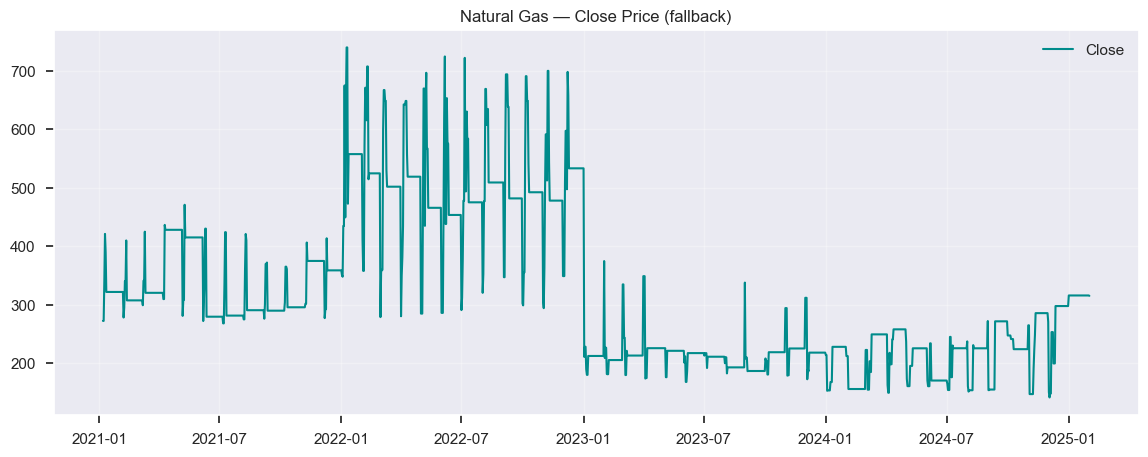

In [5]:
# Cell 5 — candlestick chart
if PLOTLY:
    fig = go.Figure(data=[
        go.Candlestick(
            x=series.index,
            open=series['open'], high=series['high'],
            low=series['low'], close=series['close'],
            name='OHLC'
        )
    ])
    fig.update_layout(
        title='Natural Gas — Interactive Candlestick Chart',
        xaxis_title='Date', yaxis_title='Price', height=600
    )
    fig.show()
else:
    plt.figure(figsize=(14,5))
    plt.plot(series.index, series['close'], label='Close', color='darkcyan')
    plt.title('Natural Gas — Close Price (fallback)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


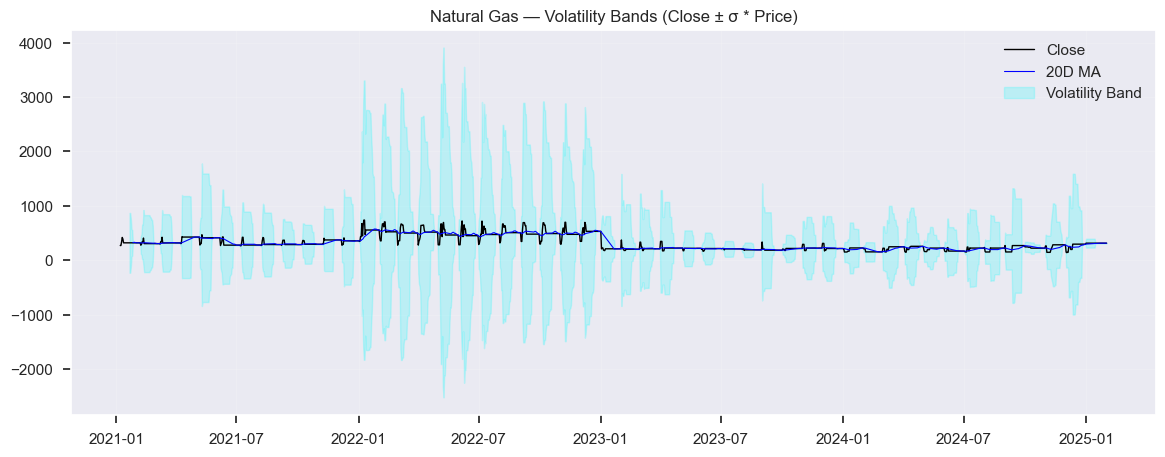

In [6]:
# Cell 6 — Volatility bands (custom visualization)
plt.figure(figsize=(14,5))
plt.plot(series.index, series['close'], label='Close', color='black', linewidth=1)
plt.plot(series.index, series['ma20'], label='20D MA', color='blue', linewidth=0.8)

# Create dynamic % bands from volatility
band = (series['vol_14'] * series['close'])
upper = series['close'] + band
lower = series['close'] - band

plt.fill_between(series.index, upper, lower, color='cyan', alpha=0.2, label='Volatility Band')
plt.title("Natural Gas — Volatility Bands (Close ± σ * Price)")
plt.legend()
plt.grid(alpha=0.15)
plt.show()


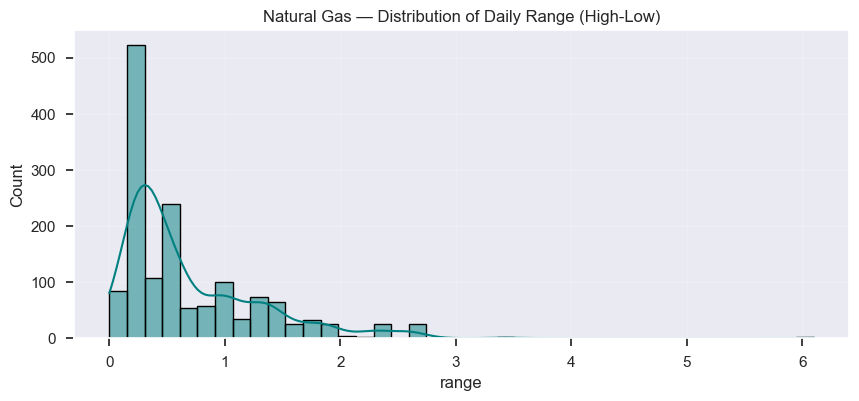

Top 5 widest ranges:
date
2022-08-06    6.1
2022-08-07    6.1
2022-03-05    3.7
2022-08-04    3.4
2022-08-05    3.4
Name: range, dtype: float64

Top 5 narrowest ranges:
date
2022-07-11    0.0
2024-01-01    0.0
2024-01-02    0.0
2025-01-01    0.0
2025-01-02    0.0
Name: range, dtype: float64


In [7]:
# Cell 7 — distribution of daily range
plt.figure(figsize=(10,4))
sns.histplot(series['range'].dropna(), bins=40, kde=True, color='teal')
plt.title("Natural Gas — Distribution of Daily Range (High-Low)")
plt.grid(alpha=0.2)
plt.show()

# Extreme moves
print("Top 5 widest ranges:")
print(series['range'].nlargest(5))

print("\nTop 5 narrowest ranges:")
print(series['range'].nsmallest(5))


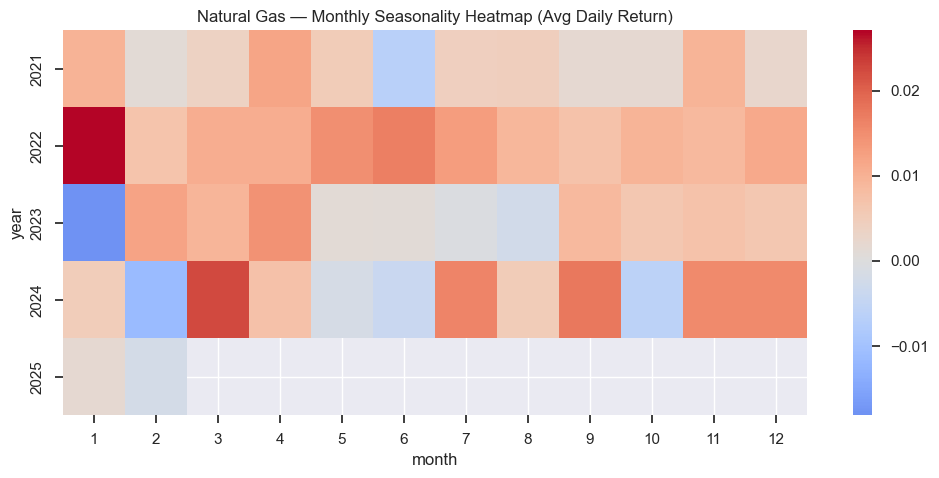

In [8]:
# Cell 8 — seasonality heatmap
dfh = series['returns'].dropna().to_frame()
dfh['year'] = dfh.index.year
dfh['month'] = dfh.index.month

pivot = dfh.pivot_table(values='returns', index='year', columns='month', aggfunc='mean')

plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap='coolwarm', center=0)
plt.title('Natural Gas — Monthly Seasonality Heatmap (Avg Daily Return)')
plt.show()


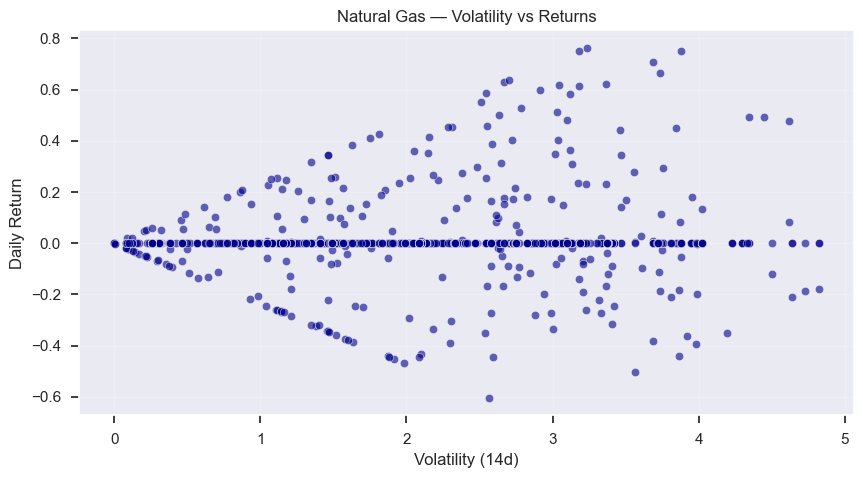

In [9]:
# Cell 9 — scatter of returns vs volatility
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=series['vol_14'], 
    y=series['returns'], 
    alpha=0.6,
    color='darkblue'
)
plt.title("Natural Gas — Volatility vs Returns")
plt.xlabel("Volatility (14d)")
plt.ylabel("Daily Return")
plt.grid(alpha=0.2)
plt.show()


In [10]:
# Cell 10 — summary card values
latest = series['close'].dropna().iloc[-1]
change_pct = (series['close'].iloc[-1] / series['close'].iloc[0] - 1) * 100
recent_vol = series['vol_14'].dropna().iloc[-1]

print("Natural Gas Snapshot:")
print("Latest price:", round(latest,2))
print("Cumulative change:", f"{change_pct:.2f}%")
print("Recent volatility (14d, annualized):", round(recent_vol,4))


Natural Gas Snapshot:
Latest price: 315.4
Cumulative change: 15.74%
Recent volatility (14d, annualized): 0.0081


In [11]:
# Cell 11 — optional lightweight baseline model
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1,6):
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)

    df_tab = df_tab.dropna().reset_index(drop=True)
    X = df_tab[[f'lag_{l}' for l in range(1,6)]].values
    y = df_tab['close'].shift(-1).ffill().values

    if len(X) > 50:
        split = int(0.8*len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = RandomForestRegressor(n_estimators=120, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = math.sqrt(mean_squared_error(y_test, preds))

        print("Baseline MAE:", round(mae,2))
        print("Baseline RMSE:", round(rmse,2))
    else:
        print("Not enough data for baseline model.")
except Exception as ex:
    print("Baseline skipped:", ex)


Baseline MAE: 31.01
Baseline RMSE: 49.28


In [12]:
# Cell 12 — final export instructions
print("NATURAL GAS showcase ready.")
print("Export to HTML for website embedding:")
print("jupyter nbconvert --to html NATGAS_showcase.ipynb --output public/notebooks/natgas_showcase.html")


NATURAL GAS showcase ready.
Export to HTML for website embedding:
jupyter nbconvert --to html NATGAS_showcase.ipynb --output public/notebooks/natgas_showcase.html
